### PDKit Gait Features and Rotation to PD Severity Based on UPDRS Score and Daily Living

In [1]:
import seaborn as sns
import synapseclient as sc
import pandas as pd
import numpy as np
import pylab as plt
import matplotlib
import matplotlib.gridspec as gridspec
import warnings
from scipy import stats
import statsmodels
from statsmodels.stats.multitest import multipletests

warnings.simplefilter("ignore")
sns.set_style("darkgrid", {"axes.facecolor": ".9", 'grid.color': '.8'})

%matplotlib inline

In [2]:
syn = sc.login()

Welcome, Aryton Tediarjo!



In [3]:
FEATURES = "syn22294860"
SAMPLE_IDENTIFIER = "syn8533708"
STD_DATA = "syn22308209"
AVG_DATA = "syn22308208"

In [4]:
class SeabornFig2Grid():
    def __init__(self, seaborngrid, fig,  subplot_spec):
        self.fig = fig
        self.sg = seaborngrid
        self.subplot = subplot_spec
        if isinstance(self.sg, sns.axisgrid.FacetGrid) or \
            isinstance(self.sg, sns.axisgrid.PairGrid):
            self._movegrid()
        elif isinstance(self.sg, sns.axisgrid.JointGrid):
            self._movejointgrid()
        self._finalize()

    def _movegrid(self):
        """ Move PairGrid or Facetgrid """
        self._resize()
        n = self.sg.axes.shape[0]
        m = self.sg.axes.shape[1]
        self.subgrid = gridspec.GridSpecFromSubplotSpec(n,m, subplot_spec=self.subplot)
        for i in range(n):
            for j in range(m):
                self._moveaxes(self.sg.axes[i,j], self.subgrid[i,j])

    def _movejointgrid(self):
        """ Move Jointgrid """
        h= self.sg.ax_joint.get_position().height
        h2= self.sg.ax_marg_x.get_position().height
        r = int(np.round(h/h2))
        self._resize()
        self.subgrid = gridspec.GridSpecFromSubplotSpec(r+1,r+1, subplot_spec=self.subplot)

        self._moveaxes(self.sg.ax_joint, self.subgrid[1:, :-1])
        self._moveaxes(self.sg.ax_marg_x, self.subgrid[0, :-1])
        self._moveaxes(self.sg.ax_marg_y, self.subgrid[1:, -1])

    def _moveaxes(self, ax, gs):
        #https://stackoverflow.com/a/46906599/4124317
        ax.remove()
        ax.figure=self.fig
        self.fig.axes.append(ax)
        self.fig.add_axes(ax)
        ax._subplotspec = gs
        ax.set_position(gs.get_position(self.fig))
        ax.set_subplotspec(gs)

    def _finalize(self):
        plt.close(self.sg.fig)
        self.fig.canvas.mpl_connect("resize_event", self._resize)
        self.fig.canvas.draw()

    def _resize(self, evt=None):
        self.sg.fig.set_size_inches(self.fig.get_size_inches())

In [5]:
def stat_func(x, y):
    vals = stats.pearsonr(x, y)
    return vals[0], vals[1]

def iqr(x):
    """
    Function for getting IQR value
    """
    return x.quantile(0.75) - x.quantile(0.25)

def get_pval_and_corr(data, metric):
    p_val = {}
    for feat in feat_used:  
        try:
            res = data[[feat, metric]].dropna()
            scale = (res[feat]- res[feat].min())/(res[feat].max() - res[feat].min())
            corr_test = (stats.pearsonr(scale,  res[metric]))
            p_val[feat] = [corr_test[0], corr_test[1]]
        except:
            pass
    p_val = pd.DataFrame(p_val).T.rename({0:"correlation", 1:"p-value"}, axis = 1)
    adj_pval = multipletests(p_val["p-value"], alpha = 0.05, method = "bonferroni")[1]
    p_val["adjusted-p-value"] = adj_pval
    return(p_val)

def visualize_relationship_feature(data_avg, 
                                   data_std, 
                                   columns, 
                                   metric,
                                   xlim = [0,1],
                                   ylim = [0,100]):
    for feat in columns:  
        try:
            scaled_feature = (data_avg[feat]-data_avg[feat].min())/(data_avg[feat].max() - data_avg[feat].min())

            ax1 = sns.jointplot(x= scaled_feature, 
                                y= data_avg[metric], 
                                kind="reg")
            ax1.annotate(stat_func, template='r = {val:.2g}; p = {p:.2g}')
            x = plt.errorbar(x= scaled_feature, 
                             y= data_avg[metric], 
                             yerr= data_std[metric],
                             fmt='o',
                        color=(0.20392156862745098, 
                               0.5411764705882353, 
                               0.7411764705882353))
            x=plt.xlim(xlim[0], xlim[1])
            x=plt.ylim(ylim[0], ylim[1])
            
            fig = plt.figure(figsize=(6,6))

            gs = gridspec.GridSpec(nrows = 1, ncols = 1)
            mg0 = SeabornFig2Grid(ax1, fig, gs[0])
            gs.tight_layout(fig)
        except:
            pass
        plt.show()

def get_agg_fog_features(df, freeze_threshold):
    """
    per paper, freeze index more than 2.5 is considered as freezing
    """
    freeze = df.copy()
    freeze["is_freeze_x"] = np.where(freeze["x_energy_freeze_index"] >= freeze_threshold, 1, 0)
    freeze["is_freeze_y"] = np.where(freeze["y_energy_freeze_index"] >= freeze_threshold, 1, 0)
    freeze["is_freeze_z"] = np.where(freeze["z_energy_freeze_index"] >= freeze_threshold, 1, 0)
    freeze["is_freeze_AA"] = np.where(freeze["AA_energy_freeze_index"] >= freeze_threshold, 1, 0)
    
    group = freeze.groupby(["healthCode","recordId"]).agg(
    {"is_freeze_x":"sum", 
     "is_freeze_y":"sum",
     "is_freeze_z":"sum",
     "is_freeze_AA":"sum",
     "window_end":"last",
     "window_start":"first"})
    group["activity_duration"] = group["window_end"] - group["window_start"]
    
    group["freeze_of_gait_per_secs_x"] = group["is_freeze_x"]/group["activity_duration"]
    group["freeze_of_gait_per_secs_y"] = group["is_freeze_y"]/group["activity_duration"]
    group["freeze_of_gait_per_secs_z"] = group["is_freeze_z"]/group["activity_duration"]
    group["freeze_of_gait_per_secs_AA"] = group["is_freeze_AA"]/group["activity_duration"]
    
    freeze_med_feat = group.reset_index()[["healthCode", 
                                           "freeze_of_gait_per_secs_x", 
                                           "freeze_of_gait_per_secs_y", 
                                           "freeze_of_gait_per_secs_z", 
                                           "freeze_of_gait_per_secs_AA"]].groupby("healthCode").median().add_suffix('_agg_med')

    freeze_iqr_feat = group.reset_index()[["healthCode", 
                                           "freeze_of_gait_per_secs_x", 
                                           "freeze_of_gait_per_secs_y", 
                                           "freeze_of_gait_per_secs_z", 
                                           "freeze_of_gait_per_secs_AA"]].groupby("healthCode").agg(iqr).add_suffix('_agg_iqr')
    return freeze_iqr_feat.join(freeze_med_feat)

def get_agg_features(data):
    ## get aggregated data for each record
    iqr_agg_feat = subset.groupby(["healthCode"])\
                            .agg(iqr).add_suffix('_agg_iqr')
    med_agg_feat = subset.groupby(["healthCode"])\
                            .median().add_suffix('_agg_med')
    counts = subset.groupby("healthCode")\
        .agg('nunique')[["createdOn"]]\
        .rename({"createdOn":"nrecords"}, axis = 1)
    return (iqr_agg_feat.join(med_agg_feat)).join(counts)

### Read Required Table

In [6]:
features = pd.read_csv(
    syn.get(FEATURES)["path"], sep = "\t")

avg_df = pd.read_csv(
    syn.get(AVG_DATA)["path"], sep = "\t", index_col = [0])

std_df = pd.read_csv(
    syn.get(STD_DATA)["path"], sep = "\t", index_col = [0])

sample_identifier = pd.read_csv(
    syn.get(SAMPLE_IDENTIFIER)["path"]).set_index("id")

### Join UPDRS Scores

In [7]:
freeze_col = list(avg_df.columns[avg_df.columns.str.contains("freeze")])[0]
list_of_metrics = ["UPDRS Total Score",
                   'Schwab and England Activities of Daily Living Scale Score', 
                   "Freezing Survey Score", 
                   'UPDRS Part 3, Motor Exam (clinician-rated) Score']


avg_joined_table = sample_identifier.join(avg_df).rename({freeze_col:"Freezing Survey Score"}, axis = 1)
std_joined_table = sample_identifier.join(std_df).rename({freeze_col:"Freezing Survey Score"}, axis = 1)


score_avg = avg_joined_table[["healthcode"] + list_of_metrics].rename(
    {"healthcode":"healthCode"}, axis = 1).set_index("healthCode")
score_std = std_joined_table[["healthcode"] + list_of_metrics].rename(
    {"healthcode":"healthCode"}, axis = 1).set_index("healthCode")

### Aggregate Features

In [8]:
hc_list = avg_joined_table["healthcode"].values
subset = features[features["healthCode"].isin(hc_list)]
agg_freeze_feat = get_agg_fog_features(subset, 2.5)
agg_gait_feat = get_agg_features(subset)
data = agg_gait_feat.join(agg_freeze_feat)
feat_used = [feat for feat in data.columns if ("createdOn" not in feat) 
             and ("window" not in feat) and ("error" not in feat) and ('nrecords' not in feat)]
data = data[feat_used]

In [9]:
metrics_avg = data.join(score_avg)
metrics_std = data.join(score_std)

### Get P-Values, Correlation between Metrics and Gait Features, and Bonferroni Corrected P-Values

In [10]:
list_of_metrics

['UPDRS Total Score',
 'Schwab and England Activities of Daily Living Scale Score',
 'Freezing Survey Score',
 'UPDRS Part 3, Motor Exam (clinician-rated) Score']

In [11]:
total_updrs_score = get_pval_and_corr(
    metrics_avg, 'UPDRS Total Score')
freezing_survey_score = get_pval_and_corr(
    metrics_avg[metrics_avg["Freezing Survey Score"] > 0], "Freezing Survey Score")
updrs_motor_exam_score = get_pval_and_corr(
    metrics_avg, 'UPDRS Part 3, Motor Exam (clinician-rated) Score')

#### a.) Total UPDRS Score

In [12]:
significant_total_updrs_score = total_updrs_score[(np.abs(total_updrs_score["correlation"]) > 0.35) & 
                                                  (updrs_motor_exam_score["p-value"] < 0.05)]
significant_total_updrs_score.sort_values("p-value", ascending = True)

,correlation,p-value,adjusted-p-value
AA_cadence_agg_iqr,-0.495366,0.001825,0.191613
AA_cadence_agg_med,-0.462993,0.003907,0.410185
y_sd_stride_duration_agg_med,0.451495,0.005032,0.528402
y_sd_stride_duration_agg_iqr,0.422171,0.009247,0.970972
z_sd_stride_duration_agg_iqr,0.420620,0.009536,1.000000
AA_stride_regularity_agg_iqr,0.414351,0.010783,1.000000
rotation_omega_agg_med,-0.407526,0.012296,1.000000
freeze_of_gait_per_secs_y_agg_med,0.393015,0.016116,1.000000
AA_energy_freeze_index_agg_med,-0.390572,0.016848,1.000000
z_sd_step_duration_agg_med,0.390301,0.016931,1.000000


#### b.) Freezing Survey Aggregated Score

In [13]:
significant_freezing_survey_score = freezing_survey_score[(np.abs(freezing_survey_score["correlation"]) > 0.35) & 
                                                          (freezing_survey_score["p-value"] < 0.05)]
significant_freezing_survey_score.sort_values("p-value", ascending = True)

,correlation,p-value,adjusted-p-value
y_avg_stride_duration_agg_med,-0.943085,0.004767,0.500505
freeze_of_gait_per_secs_y_agg_med,0.938202,0.005610,0.589100
y_avg_step_duration_agg_iqr,-0.915016,0.010526,1.000000
freeze_of_gait_per_secs_z_agg_iqr,0.904202,0.013326,1.000000
y_avg_step_duration_agg_med,-0.886472,0.018601,1.000000
z_avg_step_duration_agg_iqr,0.882383,0.019937,1.000000
y_speed_of_gait_agg_med,-0.858215,0.028729,1.000000
y_energy_freeze_index_agg_iqr,0.845568,0.033932,1.000000
z_avg_stride_duration_agg_iqr,0.832780,0.039606,1.000000
y_loco_freeze_index_agg_iqr,-0.817719,0.046811,1.000000


#### c.) UPDRS Motor Exam

In [14]:
significant_updrs_p3_score = updrs_motor_exam_score[(np.abs(updrs_motor_exam_score["correlation"]) > 0.35) 
                                                   & (updrs_motor_exam_score["p-value"] < 0.05)]
significant_updrs_p3_score.sort_values("p-value", ascending = True)

,correlation,p-value,adjusted-p-value
rotation_omega_agg_med,-0.454109,0.001960,0.205754
AA_stride_regularity_agg_iqr,0.405169,0.006366,0.668422
z_sd_stride_duration_agg_iqr,0.401252,0.006945,0.729248
AA_cadence_agg_iqr,-0.389041,0.009054,0.950619
AA_step_regularity_agg_iqr,0.385478,0.009764,1.000000
AA_cadence_agg_med,-0.383881,0.010098,1.000000
x_energy_freeze_index_agg_iqr,0.380090,0.010929,1.000000
z_sd_step_duration_agg_med,0.370305,0.013351,1.000000


### Visualization of each Survey to Significant Gait Features (Sorted Ascending from Lowest P-Val)

#### i). UPDRS Total Score

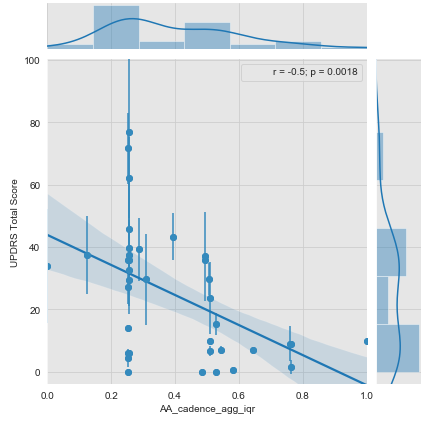

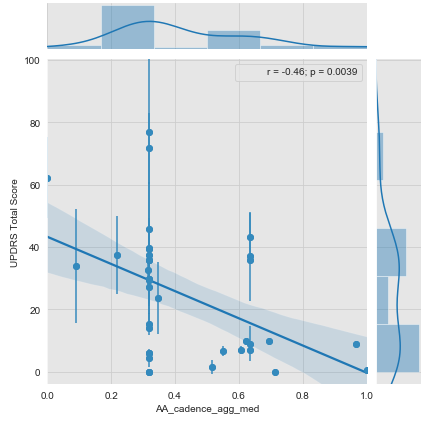

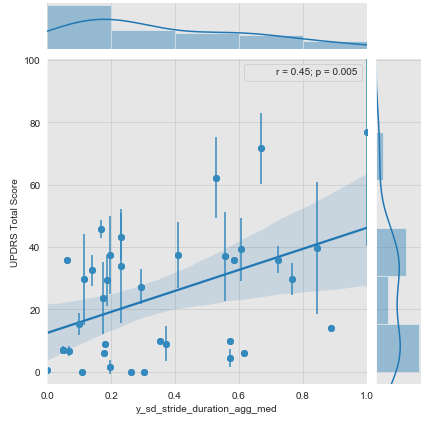

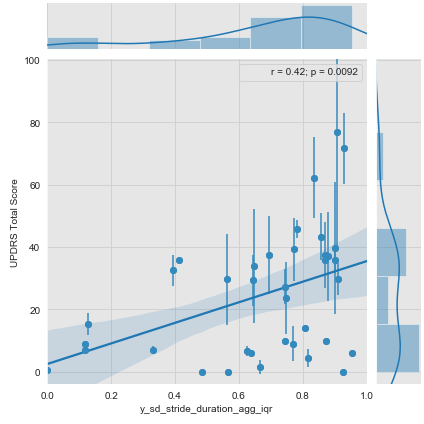

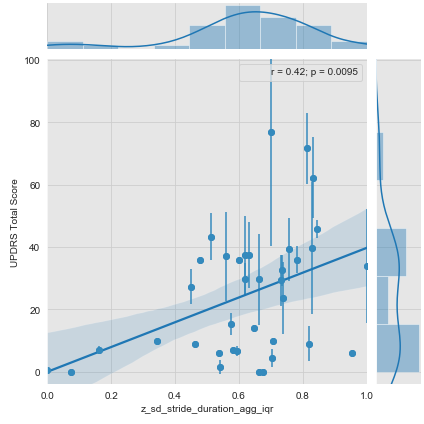

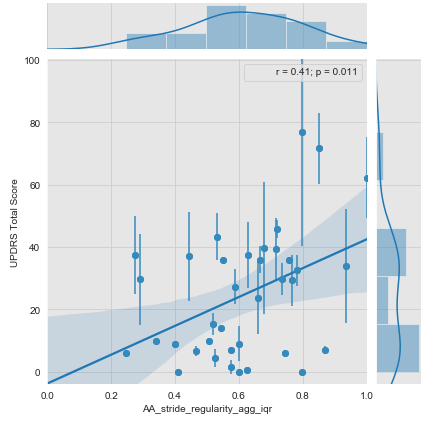

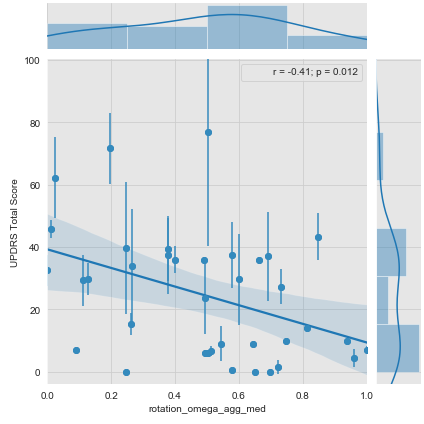

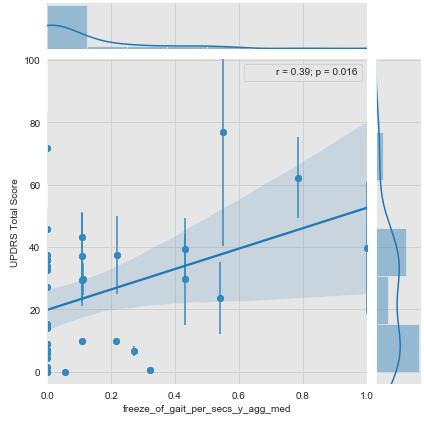

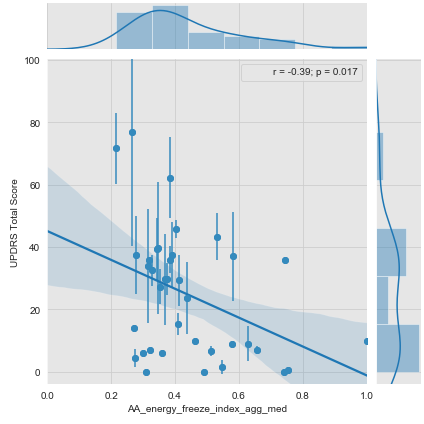

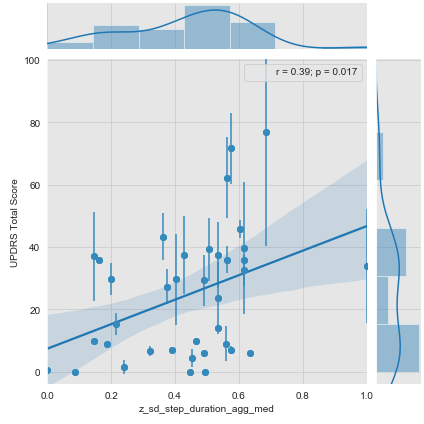

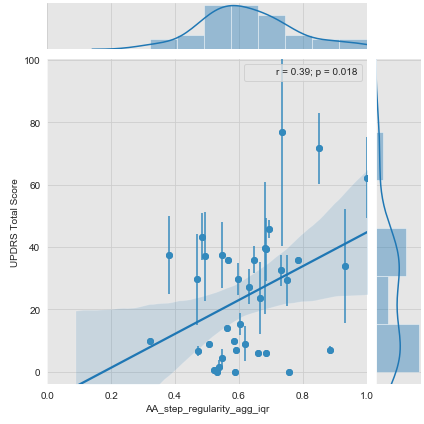

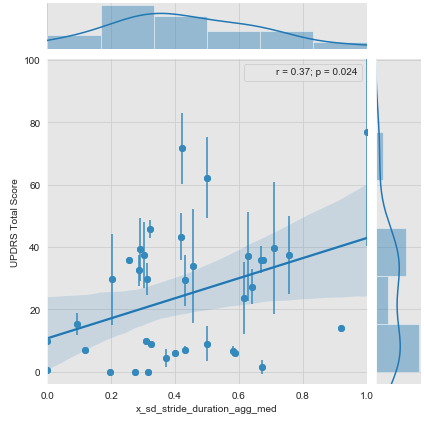

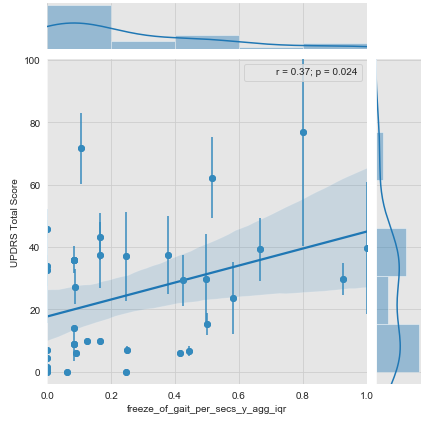

In [15]:
visualize_relationship_feature(
    metrics_avg, metrics_std, 
    significant_total_updrs_score.sort_values("p-value").index,
    'UPDRS Total Score', ylim = [-4, 100.5])

#### b.) UPRS Motor Exam Score

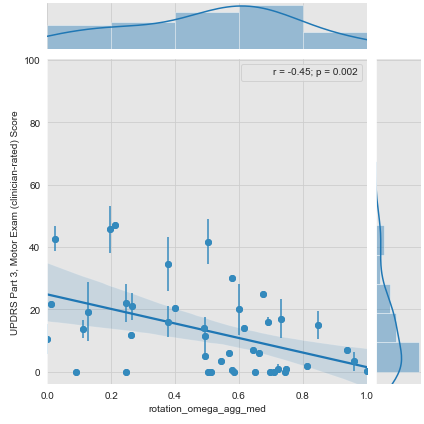

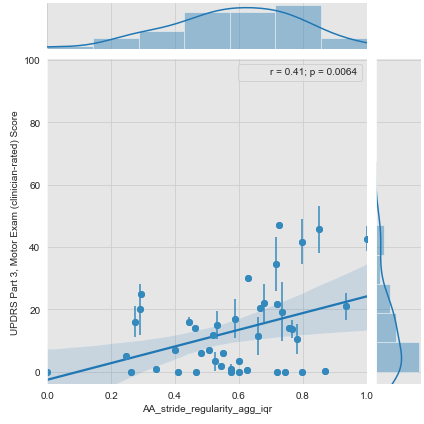

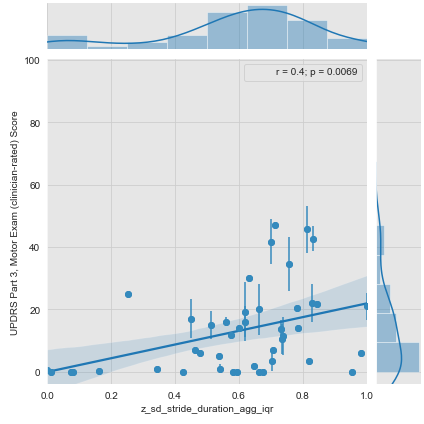

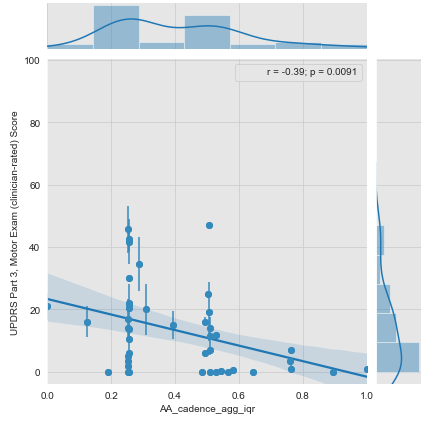

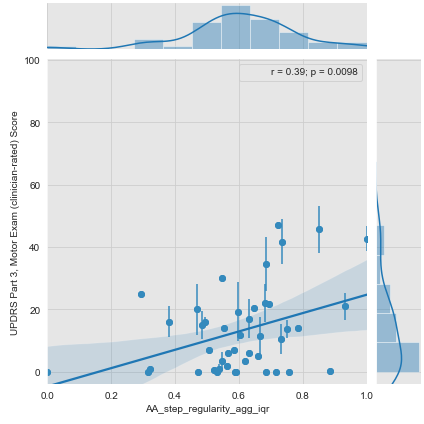

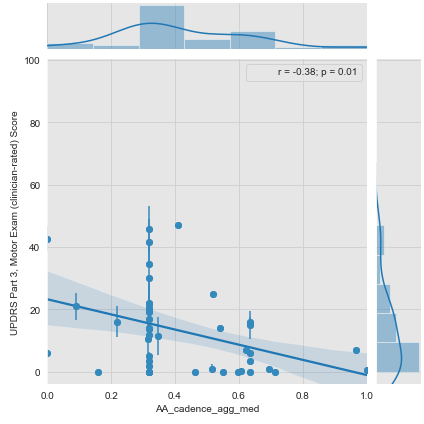

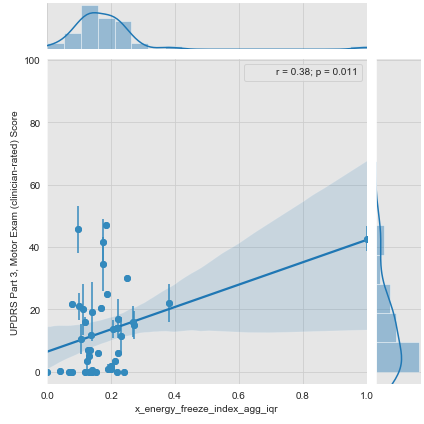

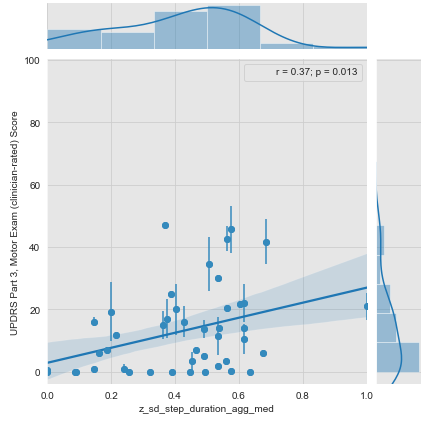

In [16]:
visualize_relationship_feature(
    metrics_avg, metrics_std, 
    significant_updrs_p3_score.sort_values("p-value").index,
    'UPDRS Part 3, Motor Exam (clinician-rated) Score', ylim = [-4, 100.5])

#### c.) Freeze Survey Aggregated Score

In [17]:
subset_user_avg = metrics_avg[metrics_avg["Freezing Survey Score"] > 0]
subset_user_std = metrics_std.loc[metrics_std.index.isin(subset_user_avg.index)]
subset_user_std["Freezing Survey Score"] = subset_user_std["Freezing Survey Score"].fillna(0)

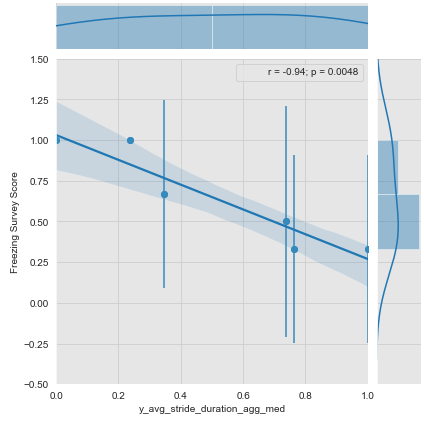

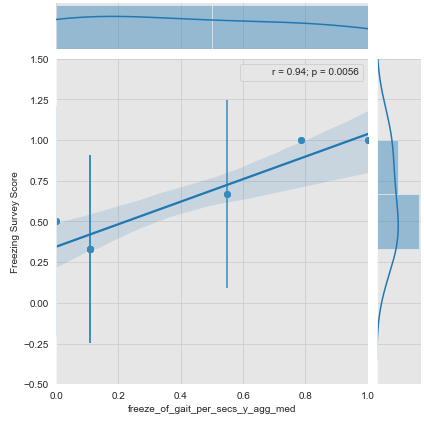

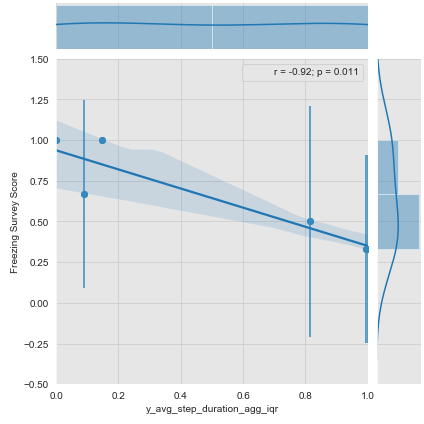

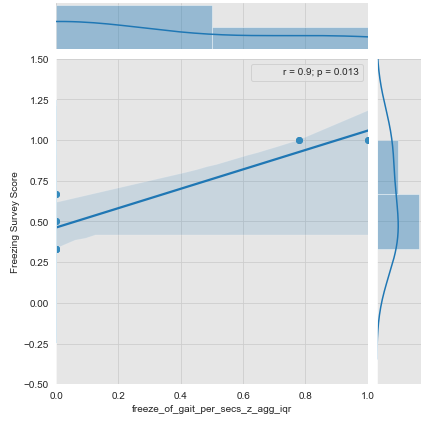

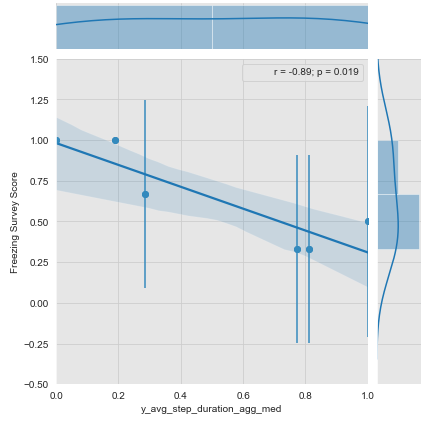

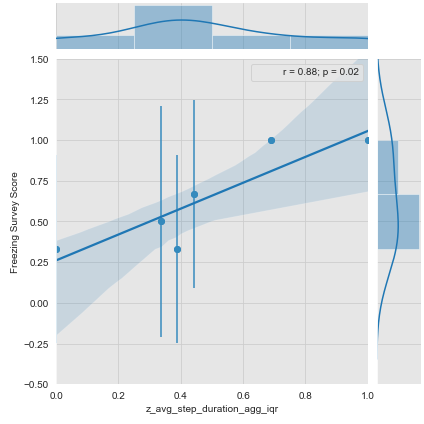

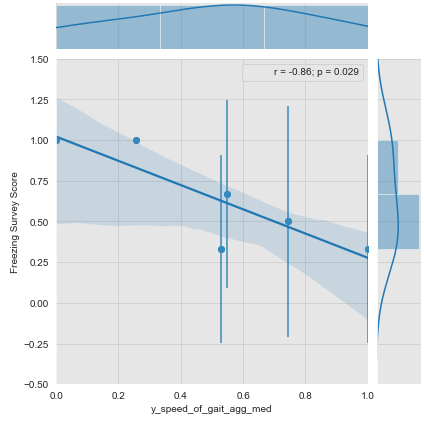

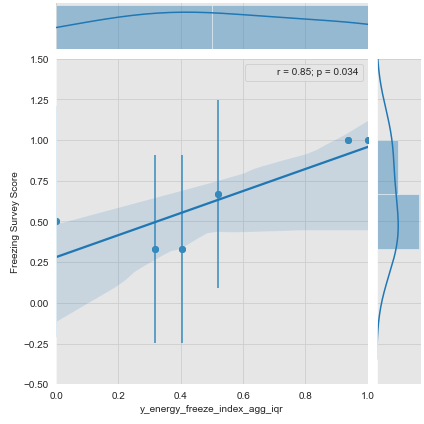

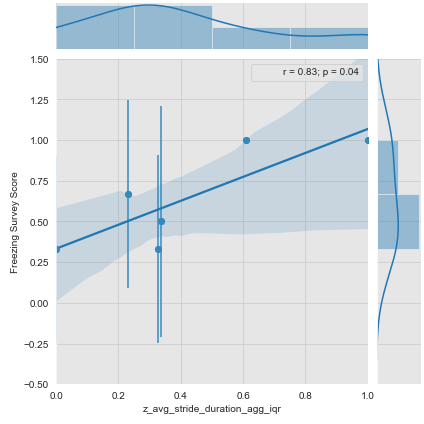

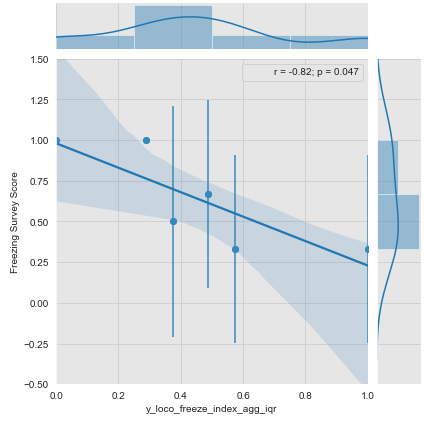

In [18]:
visualize_relationship_feature(
    subset_user_avg, subset_user_std, 
    significant_freezing_survey_score.sort_values("p-value").index,
    'Freezing Survey Score', ylim = [-0.5, 1.5], xlim = [0, 1])